In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
#vgg16を使う
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import torch

from misc_functions import get_example_params, convert_to_grayscale, save_gradient_images

In [3]:
vgg16 = models.vgg16(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)

In [ ]:
image_size = (256, 256) 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])

img = Image.open('cat.jpg')
img = image_transform(img)
img = img.unsqueeze(0)

# 認識結果の top-5 の結果の表示
SYNSET_FILE='1000.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')

#画像の種類を認識し、正しいカテゴリーを確認する
vgg16.eval()
with torch.no_grad():
    out=softmax(vgg16(img)).numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))
print(top5idx)

In [4]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [ ]:
#Vanilla Backpropagation
# Get params
target_example = 2
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)
# Vanilla backprop
VBP = VanillaBackprop(pretrained_model)
# Generate gradients
vanilla_grads = VBP.generate_gradients(prep_img, target_class)
# Save colored gradients
save_gradient_images(vanilla_grads, file_name_to_export + '_Vanilla_BP_color')
# Convert to grayscale
grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
# Save grayscale gradients
save_gradient_images(grayscale_vanilla_grads, file_name_to_export + '_Vanilla_BP_gray')
print('Vanilla backprop completed')

In [ ]:
result1 = Image.open("results/whale_Vanilla_BP_color.jpg")
result2 = Image.open("results/whale_Vanilla_BP_gray.jpg")
original_image = original_image.resize((224,224))
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(original_image)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(result1)
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.imshow(result2)
plt.xticks([])
plt.yticks([])

plt.show()

In [5]:
#Smooth Backpropagation
import numpy as np

from torch.autograd import Variable
import torch

from misc_functions import (get_example_params,
                            convert_to_grayscale,
                            save_gradient_images)
#from vanilla_backprop import VanillaBackprop
# from guided_backprop import GuidedBackprop  # To use with guided backprop


def generate_smooth_grad(Backprop, prep_img, target_class, param_n, param_sigma_multiplier):
    """
        Generates smooth gradients of given Backprop type. You can use this with both vanilla
        and guided backprop
    Args:
        Backprop (class): Backprop type
        prep_img (torch Variable): preprocessed image
        target_class (int): target class of imagenet
        param_n (int): Amount of images used to smooth gradient
        param_sigma_multiplier (int): Sigma multiplier when calculating std of noise
    """
    # Generate an empty image/matrix
    smooth_grad = np.zeros(prep_img.size()[1:])

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(prep_img) - torch.min(prep_img)).item()
    for x in range(param_n): #入力画像にノイズを乗せて、繰り返しBPをする
        # Generate noise
        noise = Variable(prep_img.data.new(prep_img.size()).normal_(mean, sigma**2))
        # Add noise to the image
        noisy_img = prep_img + noise
        # Calculate gradients
        vanilla_grads = Backprop.generate_gradients(noisy_img, target_class)
        # Add gradients to smooth_grad
        smooth_grad = smooth_grad + vanilla_grads
    # Average it out
    smooth_grad = smooth_grad / param_n
    return smooth_grad

In [9]:
# Get params
target_example = 4
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

VBP = VanillaBackprop(pretrained_model)
# GBP = GuidedBackprop(pretrained_model)  # if you want to use GBP dont forget to
# change the parametre in generate_smooth_grad

param_n = 50
param_sigma_multiplier = 4
smooth_grad = generate_smooth_grad(VBP,  # ^This parameter
                                   prep_img,
                                   target_class,
                                   param_n,
                                   param_sigma_multiplier)

# Save colored gradients
save_gradient_images(smooth_grad, file_name_to_export + '_SmoothGrad_color')
# Convert to grayscale
grayscale_smooth_grad = convert_to_grayscale(smooth_grad)
# Save grayscale gradients
save_gradient_images(grayscale_smooth_grad, file_name_to_export + '_SmoothGrad_gray')
print('Smooth grad completed')

Smooth grad completed


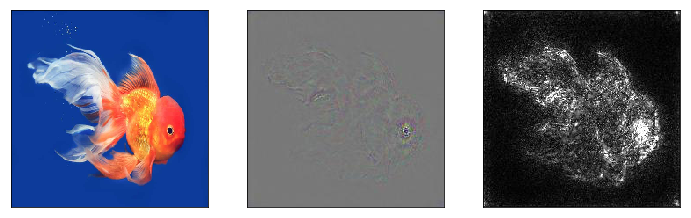

In [10]:
result1 = Image.open("results/goldfish_SmoothGrad_color.jpg")
result2 = Image.open("results/goldfish_SmoothGrad_gray.jpg")
original_image = original_image.resize((224,224))
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(original_image)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(result1)
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.imshow(result2)
plt.xticks([])
plt.yticks([])

plt.show()

In [11]:
#guided backpropagation
from torch.nn import ReLU

from misc_functions import (get_example_params,
                            convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency)


class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [21]:
target_example = 4
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Guided backprop
GBP = GuidedBackprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')

Guided backprop completed


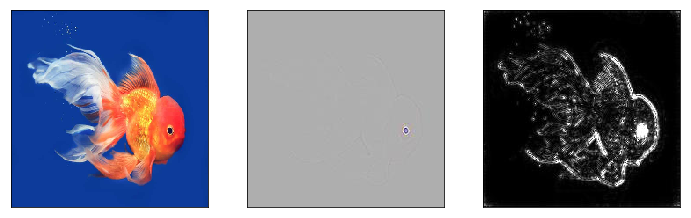

In [22]:
result1 = Image.open("results/goldfish_Guided_BP_color.jpg")
result2 = Image.open("results/goldfish_Guided_BP_gray.jpg")
original_image = original_image.resize((224,224))
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(original_image)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(result1)
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.imshow(result2)
plt.xticks([])
plt.yticks([])

plt.show()